In [1]:
pip install scikit-optimize


Note: you may need to restart the kernel to use updated packages.


Selected Features: Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel',
       'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manufacturing Director', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_Yes'],
      dtype='object')
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each 

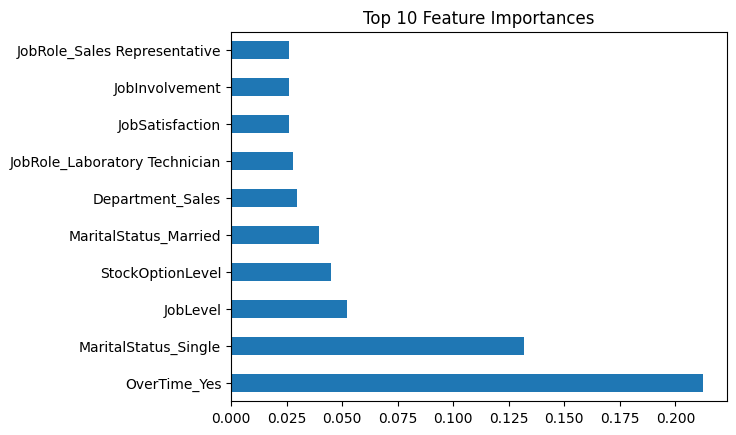

In [5]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import VotingClassifier
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

low_variance_cols = [col for col in df.columns if df[col].nunique() == 1]
df = df.drop(columns=low_variance_cols)

categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 
                'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 
                'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 
                'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 
                'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

X = df.drop(columns=['Attrition'])
y = LabelEncoder().fit_transform(df['Attrition'])

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
selector = RFECV(xgb, step=1, cv=5, scoring='accuracy', n_jobs=-1)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
print(f"Selected Features: {X.columns[selector.support_]}")

opt = BayesSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    search_spaces={
        'learning_rate': (0.01, 0.3, 'log-uniform'),
        'max_depth': (3, 10),
        'n_estimators': (50, 300),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.6, 1.0)
    },
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
opt.fit(X_train_selected, y_train)

best_xgb = opt.best_estimator_
print("Best Parameters:", opt.best_params_)

rf = RandomForestClassifier(random_state=42)
voting_clf = VotingClassifier(estimators=[
    ('xgb', best_xgb),
    ('rf', rf)
], voting='soft', n_jobs=-1)
voting_clf.fit(X_train_selected, y_train)

y_pred = voting_clf.predict(X_test_selected)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

feature_importances = pd.Series(best_xgb.feature_importances_, index=X.columns[selector.support_])
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()
